## Module 3 Homework (2025 Cohort)

In this homework, we’ll work with categorical variables, build our first machine learning models (Decision Trees), and perform hyperparameter tuning.

💡 Your goal is to read through the provided code and make slight extensions. Specifically:
- Add more columns to the dataframe.
- Define new “handcrafted” rules to predict growth.
- Analyze whether the ML model produces **unique** predictions (i.e., cases where only the ML model is correct compared to other “hand” rules).
- Tune the Decision Tree by optimizing its complexity (i.e., the **depth** hyperparameter).


Please use the [Colab Module 3](https://github.com/DataTalksClub/stock-markets-analytics-zoomcamp/blob/main/03-modeling/%5B2025%5D_Module_3_Colab_Time_Series_Modeling.ipynb) for all tasks to ensure you have the same dataframe used for the Modeling part, as covered during the lecture. 

**HINT**: If you want to avoid data truncation in GitHub's UI, try either of the following options:
* Open the notebook in [Colab, using the GitHub link to the notebook](https://colab.research.google.com/github/DataTalksClub/stock-markets-analytics-zoomcamp/blob/main/03-modeling/%5B2025%5D_Module_3_Colab_Time_Series_Modeling.ipynb).
* Clone the repository to a local folder and open the notebook in Jupyter Notebook.

Preparing Data

In [1]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

import seaborn as sns

In [4]:
!gdown https://drive.google.com/file/d/1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB/view?usp=sharing --fuzzy -O ./content/

Downloading...
From (original): https://drive.google.com/uc?id=1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB
From (redirected): https://drive.google.com/uc?id=1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB&confirm=t&uuid=3c555fab-d994-46ab-92fd-2fb8e0c84836
To: /home/ubuntu/projects/sma_zoomcamp/03-modeling/content/stocks_df_combined_2025_06_13.parquet.brotli
100%|█████████████████████████████████████████| 130M/130M [00:01<00:00, 110MB/s]


In [5]:
df_full = pd.read_parquet("./content/stocks_df_combined_2025_06_13.parquet.brotli", )

In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230262 entries, 0 to 5700
Columns: 203 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 302.2+ MB


In [7]:
df_full.keys()

Index(['Open', 'High', 'Low', 'Close_x', 'Volume', 'Dividends', 'Stock Splits',
       'Ticker', 'Year', 'Month',
       ...
       'growth_brent_oil_7d', 'growth_brent_oil_30d', 'growth_brent_oil_90d',
       'growth_brent_oil_365d', 'growth_btc_usd_1d', 'growth_btc_usd_3d',
       'growth_btc_usd_7d', 'growth_btc_usd_30d', 'growth_btc_usd_90d',
       'growth_btc_usd_365d'],
      dtype='object', length=203)

In [8]:
df_full.tail()

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
5696,3664.000000,3708.899902,3662.199951,3678.899902,898170.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.045051,1.002542,0.875424,0.847856,1.042540,1.056555,1.041675,1.053467,1.331054,1.583593
5697,3704.000000,3704.000000,3667.199951,3679.800049,1454535.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.046479,1.015336,0.869910,0.824843,0.999666,1.043948,1.045762,1.059083,1.316939,1.586155
5698,3689.899902,3692.000000,3656.100098,3684.800049,1265737.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.079530,1.085914,0.908937,0.875957,0.985755,1.027345,1.037760,1.057130,1.340706,1.614189
5699,3684.800049,3708.000000,3585.000000,3603.899902,2335718.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.056834,1.098859,0.913112,0.884807,0.974628,0.960424,1.042856,1.016888,1.261524,1.552274
5700,3501.199951,3596.000000,3485.899902,3587.399902,1981445.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.144465,1.194753,0.974147,0.963525,1.001529,0.962213,1.016291,1.024643,1.257850,1.589225


In [9]:
# growth indicators (but not future growth)
GROWTH = [g for g in df_full.keys() if (g.find('growth_')==0)&(g.find('future')<0)]
print(GROWTH)

['growth_1d', 'growth_3d', 'growth_7d', 'growth_30d', 'growth_90d', 'growth_365d', 'growth_dax_1d', 'growth_dax_3d', 'growth_dax_7d', 'growth_dax_30d', 'growth_dax_90d', 'growth_dax_365d', 'growth_snp500_1d', 'growth_snp500_3d', 'growth_snp500_7d', 'growth_snp500_30d', 'growth_snp500_90d', 'growth_snp500_365d', 'growth_dji_1d', 'growth_dji_3d', 'growth_dji_7d', 'growth_dji_30d', 'growth_dji_90d', 'growth_dji_365d', 'growth_epi_1d', 'growth_epi_3d', 'growth_epi_7d', 'growth_epi_30d', 'growth_epi_90d', 'growth_epi_365d', 'growth_gold_1d', 'growth_gold_3d', 'growth_gold_7d', 'growth_gold_30d', 'growth_gold_90d', 'growth_gold_365d', 'growth_wti_oil_1d', 'growth_wti_oil_3d', 'growth_wti_oil_7d', 'growth_wti_oil_30d', 'growth_wti_oil_90d', 'growth_wti_oil_365d', 'growth_brent_oil_1d', 'growth_brent_oil_3d', 'growth_brent_oil_7d', 'growth_brent_oil_30d', 'growth_brent_oil_90d', 'growth_brent_oil_365d', 'growth_btc_usd_1d', 'growth_btc_usd_3d', 'growth_btc_usd_7d', 'growth_btc_usd_30d', 'growt

<Axes: >

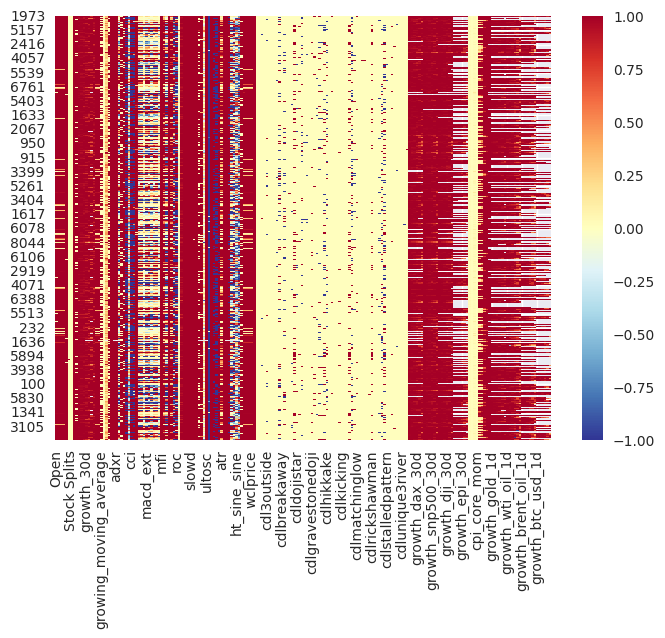

In [10]:
sns.heatmap(df_full.select_dtypes(include=['number']).sample(frac=0.01),     
            vmin=-1, vmax=1, cmap='RdYlBu_r')

<Axes: >

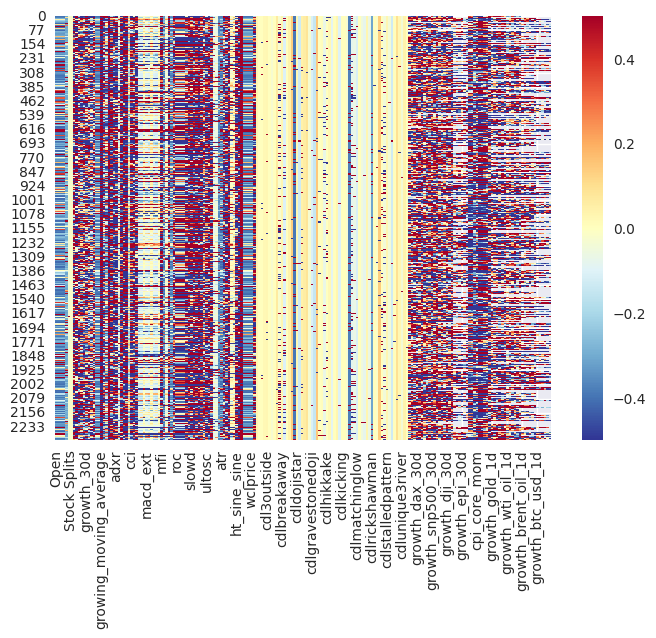

In [11]:
from sklearn.preprocessing import StandardScaler
sampled = df_full.select_dtypes('number').sample(frac=0.01)
scaler = StandardScaler()
normalized = pd.DataFrame(scaler.fit_transform(sampled), columns=sampled.columns)
sns.heatmap(normalized, vmin=-0.5, vmax=0.5, cmap='RdYlBu_r')

<Axes: >

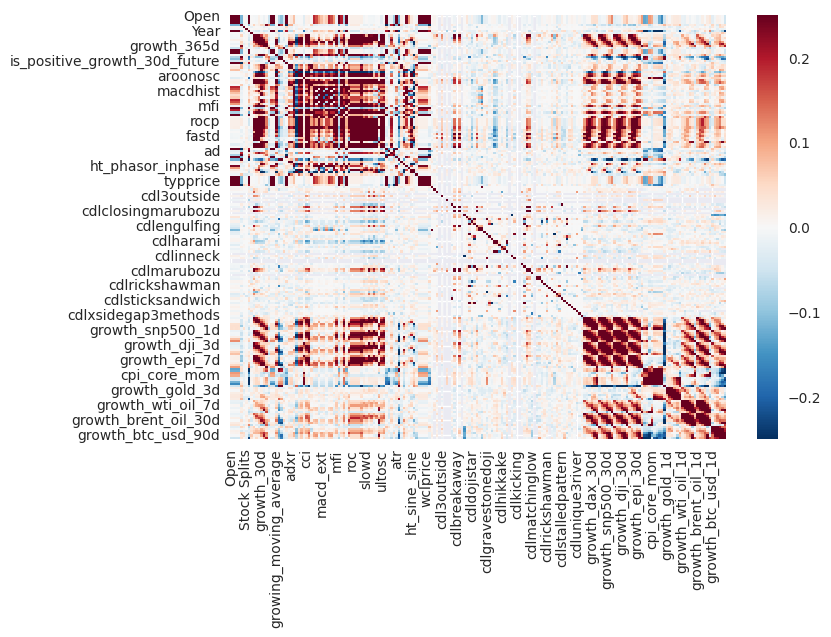

In [12]:
sns.heatmap(df_full.select_dtypes('number').sample(frac=0.01).corr(),
           vmin=-0.25, vmax=0.25, cmap='RdBu_r')

/home/ubuntu/miniconda3/envs/stocks/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ubuntu/miniconda3/envs/stocks/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


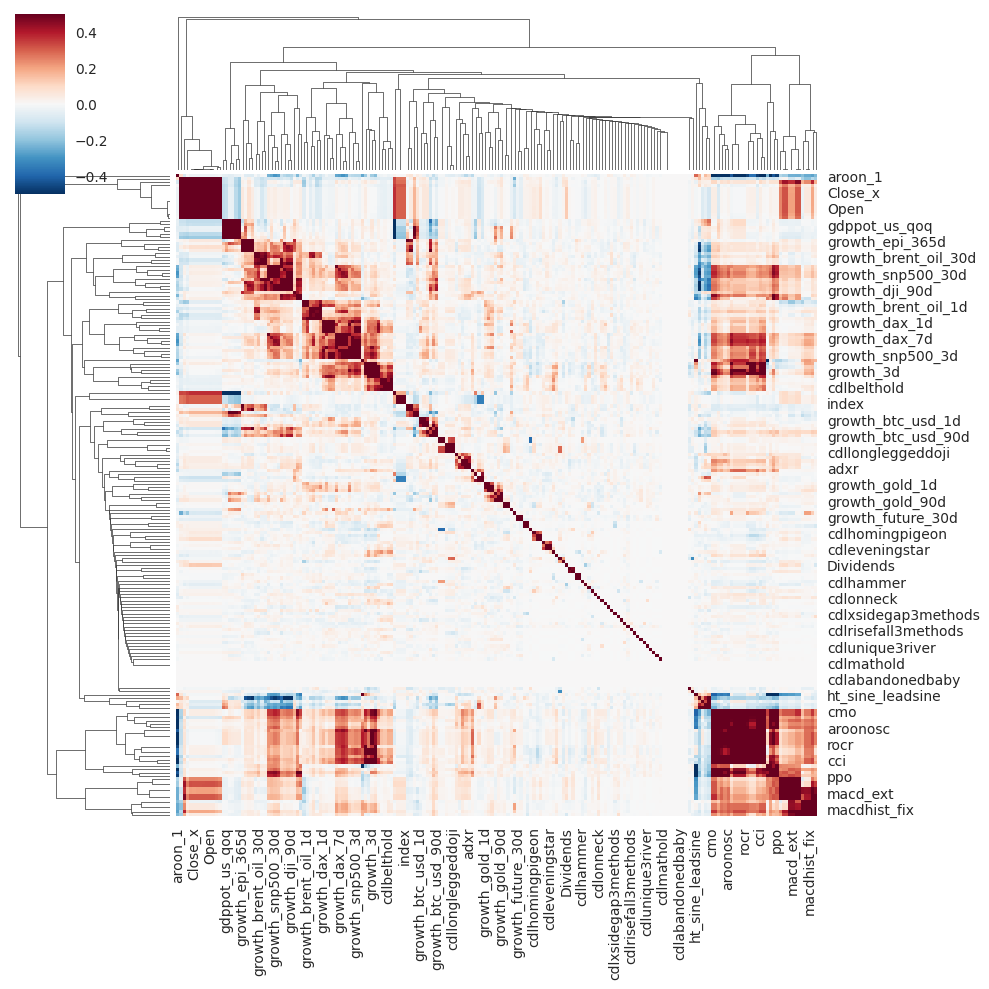

In [13]:
sns.clustermap(normalized.corr().fillna(0),
              vmin=-0.5, vmax=0.5, cmap='RdBu_r')

In [14]:
# leaving only Volume ==> generate ln(Volume)
OHLCV = ['Open','High','Low','Close','Adj Close_x','Volume']
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']

TO_PREDICT = [g for g in df_full.keys() if (g.find('future')>=0)]
print(TO_PREDICT)

TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Adj Close_y'] + CATEGORICAL + OHLCV
print(TO_DROP)

['growth_future_30d', 'is_positive_growth_30d_future']
['Year', 'Date', 'index_x', 'index_y', 'index', 'Quarter', 'Adj Close_y', 'Month', 'Weekday', 'Ticker', 'ticker_type', 'Open', 'High', 'Low', 'Close', 'Adj Close_x', 'Volume']


In [15]:
# let's define on more custom numerical features
df_full['ln_volume'] = df_full.Volume.apply(lambda x: np.log(x))

# manually defined features
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']
# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']

TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')

MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']

NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df_full.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP]
print(OTHER)

df_full.Ticker.nunique()

/tmp/ipykernel_2866315/1214213489.py:2: RuntimeWarning: divide by zero encountered in log
  df_full['ln_volume'] = df_full.Volume.apply(lambda x: np.log(x))


Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']
['Close_x', 'Dividends', 'Stock Splits', 'growth_future_30d', 'is_positive_growth_30d_future', 'Close_y']


33

In [16]:
# tickers, min-max date, count of daily observations
df_full.groupby(['Ticker'])['Date'].agg(['min','max','count']).sort_values('count')[::-1].head(10)

,min,max,count
Ticker,,,
LLY,1972-06-01,2025-06-13,13371
JPM,1980-03-17,2025-06-13,11405
AAPL,1980-12-12,2025-06-13,11217
NVO,1981-04-30,2025-06-13,11122
MSFT,1986-03-13,2025-06-13,9891
CDI.PA,1992-01-27,2025-06-13,8610
TTE,1991-10-25,2025-06-13,8469
ASML,1995-03-15,2025-06-13,7614
SAP,1995-09-18,2025-06-13,7485


In [17]:
# truncated df_full with 25 years of data (and defined growth variables)
df = df_full[df_full.Date>='2000-01-01']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 204 entries, Open to ln_volume
dtypes: datetime64[ns](3), float64(130), int32(64), int64(5), object(2)
memory usage: 253.1+ MB


In [18]:
# let look at the features count and df size:
df[NUMERICAL].info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 184 entries, growth_1d to DGS10
dtypes: float64(121), int32(62), int64(1)
memory usage: 225.3 MB


In [19]:
print(CATEGORICAL)

['Month', 'Weekday', 'Ticker', 'ticker_type']


In [20]:
# dummy variables are not generated from Date and numeric variables
df.loc[:,'Month'] = df.Month.dt.strftime('%B')
df.loc[:,'Weekday'] = df.Weekday.astype(str)

/tmp/ipykernel_2866315/43129475.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['January' 'January' 'January' ... 'June' 'June' 'June']' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.loc[:,'Month'] = df.Month.dt.strftime('%B')
/tmp/ipykernel_2866315/43129475.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['0' '1' '2' ... '2' '3' '4']' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[:,'Weekday'] = df.Weekday.astype(str)


In [21]:
# Generate dummy variables (no need for bool, let's have int32 instead)
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')

# TODO 1: define more categorical features, e.g. all combinations for <September+weekday>  (you'll see that September is actually an important dummy in one of the models)

dummy_variables.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Data columns (total 55 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Month_April           191795 non-null  int32
 1   Month_August          191795 non-null  int32
 2   Month_December        191795 non-null  int32
 3   Month_February        191795 non-null  int32
 4   Month_January         191795 non-null  int32
 5   Month_July            191795 non-null  int32
 6   Month_June            191795 non-null  int32
 7   Month_March           191795 non-null  int32
 8   Month_May             191795 non-null  int32
 9   Month_November        191795 non-null  int32
 10  Month_October         191795 non-null  int32
 11  Month_September       191795 non-null  int32
 12  Weekday_0             191795 non-null  int32
 13  Weekday_1             191795 non-null  int32
 14  Weekday_2             191795 non-null  int32
 15  Weekday_3             191795 non-null 

In [22]:
# get dummies names in a list
DUMMIES = dummy_variables.keys().to_list()

# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df, dummy_variables], axis=1)

df_with_dummies[NUMERICAL+DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 239 entries, growth_1d to ticker_type_US
dtypes: float64(121), int32(117), int64(1)
memory usage: 265.6 MB


In [23]:
print(TO_PREDICT)

corr_is_positive_growth_30d_future = df_with_dummies[NUMERICAL+DUMMIES+TO_PREDICT].corr()['is_positive_growth_30d_future']

# create a dataframe for an easy way to sort
corr_is_positive_growth_30d_future_df = pd.DataFrame(corr_is_positive_growth_30d_future)

corr_is_positive_growth_30d_future_df.sort_values(by='is_positive_growth_30d_future').head(5)

['growth_future_30d', 'is_positive_growth_30d_future']


,is_positive_growth_30d_future
DGS10,-0.067204
DGS5,-0.059812
gdppot_us_yoy,-0.058374
gdppot_us_qoq,-0.058125
growth_brent_oil_365d,-0.056158


In [24]:
corr_is_positive_growth_30d_future_df.sort_values(by='is_positive_growth_30d_future').tail(8)

,is_positive_growth_30d_future
growth_btc_usd_7d,0.028577
Month_November,0.033807
Month_October,0.035410
growth_future_30d,0.696468
is_positive_growth_30d_future,1.000000
cdl3starsinsouth,NaN
cdlconcealbabyswall,NaN
cdlmathold,NaN


In [25]:
corr_growth_future_30d = df_with_dummies[NUMERICAL+DUMMIES+TO_PREDICT].corr()['growth_future_30d']

corr_growth_future_30d_df = pd.DataFrame(corr_growth_future_30d)

corr_growth_future_30d_df.sort_values(by='growth_future_30d').head(5)

,growth_future_30d
growth_brent_oil_365d,-0.084665
growth_dji_365d,-0.075940
growth_dax_365d,-0.060016
growth_wti_oil_365d,-0.055917
growth_snp500_365d,-0.055443


In [26]:
corr_growth_future_30d_df.sort_values(by='growth_future_30d').tail(8)

,growth_future_30d
ln_volume,0.052015
Ticker_NVDA,0.052434
Month_October,0.054752
is_positive_growth_30d_future,0.696468
growth_future_30d,1.000000
cdl3starsinsouth,NaN
cdlconcealbabyswall,NaN
cdlmathold,NaN


In [27]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.6).
        val_prop (float): Proportion of data for validation set (default: 0.2).
        test_prop (float): Proportion of data for test set (default: 0.2).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

In [28]:
min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

df_with_dummies['split'].value_counts()/len(df_with_dummies)

split
train         0.676399
test          0.163758
validation    0.159843
Name: count, dtype: float64

In [29]:
# remove the "segmentation" problem (warning message on df performance after many joins and data transformations)
new_df = df_with_dummies.copy()

In [30]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 260 entries, Open to split
dtypes: datetime64[ns](2), float64(130), int32(118), int64(5), object(5)
memory usage: 295.6+ MB


In [31]:
df_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 260 entries, Open to split
dtypes: datetime64[ns](2), float64(130), int32(118), int64(5), object(5)
memory usage: 295.6+ MB


### Question 1: Dummies for Month and Week-of-Month

**What is the ABSOLUTE CORRELATION VALUE of the most correlated dummy variable <month>_w<week_of_month> with the binary outcome `is_positive_growth_30d_future`?**

From the correlation analysis and modeling, you may have observed that October and November are potentially important seasonal months. In this task, you'll go further by generating dummy variables for both the **Month** and **Week-of-Month** (starting from 1). For example, the first week of October should be coded as: `'October_w1'`.

Once you've generated these new variables, identify the one with the **highest absolute correlation** with `is_positive_growth_30d_future`, and round the result to **three decimal places**.


#### Suggested Steps

1. Use [this StackOverflow reference](https://stackoverflow.com/questions/25249033/week-of-a-month-pandas) to compute the week of the month using the following formula:
  ```python
  (d.day - 1) // 7 + 1
  ```
2. Create a new string variable that combines the month name and week of the month.
Example: 'October_w1', 'November_w2', etc.

3. Add the new variable (e.g., `month_wom`) to your set of **categorical features**.

   Your updated categorical feature list should include:
   - `'Month'`
   - `'Weekday'`
   - `'Ticker'`
   - `'ticker_type'`
   - `'month_wom'`

4. Use [`pandas.get_dummies()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) to generate dummy variables for all categorical features.

   This should result in approximately **115 dummy variables**, including around **60** for the `month_wom` feature (`12 months × up to 5 weeks`).

5. Use [`DataFrame.corr()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) to compute the correlation between each feature and the target variable `is_positive_growth_30d_future`.

6. Filter the correlation results to include only the dummy variables generated from `month_wom`.

7. Create a new column named `abs_corr` in the correlation results that stores the **absolute value** of the correlations.

8. Sort the correlation results by `abs_corr` in **descending** order.

9. Identify and report the **highest absolute correlation value** among the `month_wom` dummy variables, rounded to **three decimal places**.


**NOTE**: new dummies will be used as features in the next tasks, please leave them in the dataset.

In [32]:
for c in new_df.columns:
    print(c, new_df[c].tail().to_list())

Open [3664.0, 3704.0, 3689.89990234375, 3684.800048828125, 3501.199951171875]
High [3708.89990234375, 3704.0, 3692.0, 3708.0, 3596.0]
Low [3662.199951171875, 3667.199951171875, 3656.10009765625, 3585.0, 3485.89990234375]
Close_x [3678.89990234375, 3679.800048828125, 3684.800048828125, 3603.89990234375, 3587.39990234375]
Volume [898170.0, 1454535.0, 1265737.0, 2335718.0, 1981445.0]
Dividends [0.0, 0.0, 0.0, 0.0, 0.0]
Stock Splits [0.0, 0.0, 0.0, 0.0, 0.0]
Ticker ['LT.NS', 'LT.NS', 'LT.NS', 'LT.NS', 'LT.NS']
Year [2025, 2025, 2025, 2025, 2025]
Month ['June', 'June', 'June', 'June', 'June']
Weekday ['0', '1', '2', '3', '4']
Date [Timestamp('2025-06-09 00:00:00'), Timestamp('2025-06-10 00:00:00'), Timestamp('2025-06-11 00:00:00'), Timestamp('2025-06-12 00:00:00'), Timestamp('2025-06-13 00:00:00')]
growth_1d [1.0061810719070685, 1.0002446781669165, 1.0013587694803125, 0.9780449019180556, 0.9954216264471526]
growth_3d [1.014449166508686, 1.0102124719086816, 1.0077947650956969, 0.979613470876

In [33]:
print(new_df.columns.to_list())

['Open', 'High', 'Low', 'Close_x', 'Volume', 'Dividends', 'Stock Splits', 'Ticker', 'Year', 'Month', 'Weekday', 'Date', 'growth_1d', 'growth_3d', 'growth_7d', 'growth_30d', 'growth_90d', 'growth_365d', 'growth_future_30d', 'SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative', 'volatility', 'is_positive_growth_30d_future', 'ticker_type', 'index_x', 'adx', 'adxr', 'apo', 'aroon_1', 'aroon_2', 'aroonosc', 'bop', 'cci', 'cmo', 'dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext', 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix', 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo', 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk', 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr', 'index_y', 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase', 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine', 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice', 'index', 'cdl2crows', '

In [34]:
new_df['week_of_month'] = new_df['Date'].apply(lambda d: (d.day-1) // 7 + 1)

In [35]:
new_df[['Date','week_of_month']]

,Date,week_of_month
3490,2000-01-03,1
3491,2000-01-04,1
3492,2000-01-05,1
3493,2000-01-06,1
3494,2000-01-07,1
...,...,...
5696,2025-06-09,2
5697,2025-06-10,2
5698,2025-06-11,2
5699,2025-06-12,2


In [36]:
new_df.groupby('week_of_month')['Date'].agg(lambda x: list(x.dt.day.sort_values().unique()))

week_of_month
1           [1, 2, 3, 4, 5, 6, 7]
2      [8, 9, 10, 11, 12, 13, 14]
3    [15, 16, 17, 18, 19, 20, 21]
4    [22, 23, 24, 25, 26, 27, 28]
5                    [29, 30, 31]
Name: Date, dtype: object

In [37]:
new_df['month_wom'] = new_df['Month'] + '_w' + new_df['week_of_month'].apply(str)

In [38]:
new_df[['Date','month_wom']]

,Date,month_wom
3490,2000-01-03,January_w1
3491,2000-01-04,January_w1
3492,2000-01-05,January_w1
3493,2000-01-06,January_w1
3494,2000-01-07,January_w1
...,...,...
5696,2025-06-09,June_w2
5697,2025-06-10,June_w2
5698,2025-06-11,June_w2
5699,2025-06-12,June_w2


In [39]:
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type', 'month_wom']

In [40]:
dummy_variables = pd.get_dummies(new_df[CATEGORICAL], dtype='int32')

In [41]:
dummy_variables.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 115 entries, Month_April to month_wom_September_w5
dtypes: int32(115)
memory usage: 85.6 MB


In [42]:
print(dummy_variables.columns.to_list())

['Month_April', 'Month_August', 'Month_December', 'Month_February', 'Month_January', 'Month_July', 'Month_June', 'Month_March', 'Month_May', 'Month_November', 'Month_October', 'Month_September', 'Weekday_0', 'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6', 'Ticker_AAPL', 'Ticker_ACN', 'Ticker_AMZN', 'Ticker_ASML', 'Ticker_AVGO', 'Ticker_BHARTIARTL.NS', 'Ticker_BRK-B', 'Ticker_CDI.PA', 'Ticker_GOOG', 'Ticker_HDB', 'Ticker_HINDUNILVR.NS', 'Ticker_IBN', 'Ticker_IDEXY', 'Ticker_INFY', 'Ticker_ITC.NS', 'Ticker_JPM', 'Ticker_LICI.NS', 'Ticker_LLY', 'Ticker_LT.NS', 'Ticker_MC.PA', 'Ticker_META', 'Ticker_MSFT', 'Ticker_NVDA', 'Ticker_NVO', 'Ticker_OR.PA', 'Ticker_RELIANCE.NS', 'Ticker_RMS.PA', 'Ticker_SAP', 'Ticker_SBIN.NS', 'Ticker_SIE.DE', 'Ticker_TCS.NS', 'Ticker_TTE', 'Ticker_V', 'ticker_type_EU', 'ticker_type_INDIA', 'ticker_type_US', 'month_wom_April_w1', 'month_wom_April_w2', 'month_wom_April_w3', 'month_wom_April_w4', 'month_wom_April_w5', 'month_wom_August

In [43]:
num_cols = new_df\
    .drop(columns=['is_positive_growth_30d_future'])\
    .select_dtypes(include=['number']).columns

len(new_df.columns), len(num_cols)

(262, 253)

In [44]:
corr_is_positive_growth_30d_future = new_df[num_cols].corrwith(new_df['is_positive_growth_30d_future'])

/home/ubuntu/miniconda3/envs/stocks/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ubuntu/miniconda3/envs/stocks/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/ubuntu/miniconda3/envs/stocks/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2888: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


In [45]:
corr_dummy_is_positive_growth_30d_future = dummy_variables.corrwith(new_df['is_positive_growth_30d_future'])

In [46]:
corr_is_positive_growth_30d_future = corr_is_positive_growth_30d_future.fillna(0).sort_values(ascending=True)
corr_is_positive_growth_30d_future

DGS10                   -0.067204
DGS5                    -0.059812
gdppot_us_yoy           -0.058374
gdppot_us_qoq           -0.058125
growth_brent_oil_365d   -0.056158
                           ...   
growth_btc_usd_3d        0.026509
growth_btc_usd_7d        0.028577
Month_November           0.033807
Month_October            0.035410
growth_future_30d        0.696468
Length: 253, dtype: float64

In [47]:
corr_dummy_is_positive_growth_30d_future = corr_dummy_is_positive_growth_30d_future.fillna(0).sort_values(ascending=True)
corr_dummy_is_positive_growth_30d_future

Month_January          -0.035311
Month_February         -0.018563
month_wom_January_w2   -0.018327
month_wom_January_w5   -0.017437
month_wom_January_w3   -0.016737
                          ...   
Ticker_V                0.023395
month_wom_October_w4    0.024968
ticker_type_US          0.025458
Month_November          0.033807
Month_October           0.035410
Length: 115, dtype: float64

In [48]:
corr_month_wom_is_positive_growth_30d_future = pd.DataFrame()
corr_month_wom_is_positive_growth_30d_future['corr'] = \
    corr_dummy_is_positive_growth_30d_future[corr_dummy_is_positive_growth_30d_future.index.str.startswith('month_wom_')]

#corr_month_wom_is_positive_growth_30d_future

In [49]:
corr_month_wom_is_positive_growth_30d_future['abs_corr'] = corr_month_wom_is_positive_growth_30d_future['corr'].abs()

In [50]:
corr_month_wom_is_positive_growth_30d_future = corr_month_wom_is_positive_growth_30d_future.sort_values('abs_corr', ascending=False)

In [51]:
corr_month_wom_is_positive_growth_30d_future.head(10)

,corr,abs_corr
month_wom_October_w4,0.024968,0.024968
month_wom_November_w3,0.022097,0.022097
month_wom_November_w2,0.018822,0.018822
month_wom_January_w2,-0.018327,0.018327
month_wom_October_w3,0.017734,0.017734
month_wom_January_w5,-0.017437,0.017437
month_wom_January_w3,-0.016737,0.016737
month_wom_February_w1,-0.016700,0.016700
month_wom_January_w4,-0.015362,0.015362
month_wom_September_w4,0.013558,0.013558


**Answer**: The highest absolute correlation value among the month_wom dummy variables is 0.025 for the variable month_wom_October_w4

### Question 2:  Define New "Hand" Rules on Macro and Technical Indicator Variables 

**What is the precision score for the best of the NEW predictions (`pred3` or `pred4`), rounded to 3 digits after the comma?**

In this task, you'll apply insights from the **visualized decision tree (`clf10`)** (see *Code Snippet 5: 1.4.4 Visualisation*) to manually define and evaluate new predictive rules.


1. **Define two new 'hand' rules** based on branches that lead to 'positive' predictions in the tree:
   - `pred3_manual_dgs10_5`:  
     ```python
     (DGS10 <= 4) & (DGS5 <= 1)
     ```
   - `pred4_manual_dgs10_fedfunds`:  
     ```python
     (DGS10 > 4) & (FEDFUNDS <= 4.795)
     ```
   > **Hint**: This is not exactly the same condition as in the estimated tree (original: `(DGS10 <= 4.825) & (DGS5 <= 0.745)`; `(DGS10 > 4.825) & (FEDFUNDS <= 4.795)`), since in that case, there are no true positive predictions for both variables. Consider why this might be the case.


2. **Extend Code Snippet 3** (Manual "hand rule" predictions):  
   - Implement and apply the above two rules (`pred3`, `pred4`) to your dataset.
   - Add the resulting predictions as new columns in your dataframe (e.g., `new_df`).

3. **Compute precision**:
   - For the rule that **does** make positive predictions on the TEST set, compute its **precision score**.
   - Use standard precision metrics (`TP / (TP + FP)`).
   - Round the precision score to **three decimal places**.  
     Example: If your result is `0.57897`, your final answer should be: `0.579`.
  > **Hint**: This should already be visible in the code output, as the `IS_CORRECT` and `PREDICTIONS` sets should automatically include the new columns.


In [52]:
new_df[['DGS5', 'DGS10', 'FEDFUNDS', 'split']]

,DGS5,DGS10,FEDFUNDS,split
3490,6.50,6.58,5.45,train
3491,6.40,6.49,5.45,train
3492,6.51,6.62,5.45,train
3493,6.46,6.57,5.45,train
3494,6.42,6.52,5.45,train
...,...,...,...,...
5696,4.09,4.49,4.33,test
5697,4.08,4.47,4.33,test
5698,4.02,4.41,4.33,test
5699,3.97,4.36,4.33,test


In [53]:
new_df['pred3_manual_dgs10_5'] = False
new_df.loc[new_df.eval('(DGS10 <= 4) & (DGS5 <= 1)'), 'pred3_manual_dgs10_5'] = True 
#.is_positive_growth_30d_future.value_counts()

In [54]:
new_df['pred4_manual_dgs10_fedfunds'] = False
new_df.loc[new_df.eval('(DGS10 > 4) & (FEDFUNDS <= 4.795)'), 'pred4_manual_dgs10_fedfunds'] = True 

In [55]:
new_df['pred3_manual_dgs10_5'].value_counts()

pred3_manual_dgs10_5
False    165557
True      26238
Name: count, dtype: int64

In [56]:
new_df['pred4_manual_dgs10_fedfunds'].value_counts()

pred4_manual_dgs10_fedfunds
False    155524
True      36271
Name: count, dtype: int64

In [57]:
pred3 = 'pred3_manual_dgs10_5'
pred4 = 'pred4_manual_dgs10_fedfunds'

to_predict = 'is_positive_growth_30d_future'

In [58]:
new_df.groupby(['split', pred3])[to_predict].agg(['mean', 'count', 'std'])

mean   count       std
split      pred3_manual_dgs10_5                            
test       False                 0.550130   30411  0.497489
           True                  0.579739     997  0.493848
train      False                 0.586527  116397  0.492458
           True                  0.639466   13333  0.480173
validation False                 0.584831   18749  0.492764
           True                  0.726990   11908  0.445525

In [59]:
new_df.groupby(['split', pred4])[to_predict].agg(['mean', 'count', 'std'])

mean  count       std
split      pred4_manual_dgs10_fedfunds                           
test       False                        0.569675  25748  0.495131
           True                         0.466431   5660  0.498916
train      False                        0.604233  99119  0.489017
           True                         0.552252  30611  0.497270
validation False                        0.640050  30657  0.479993

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, classification_report

In [61]:
prec = precision_score(
    y_true=new_df[new_df.split=='test'][to_predict],
    y_pred=new_df[new_df.split=='test'][pred3])
round(prec, 3)

0.58

In [62]:
prec = precision_score(
    y_true=new_df[new_df.split=='test'][to_predict],
    y_pred=new_df[new_df.split=='test'][pred4])
round(prec, 3)

0.466

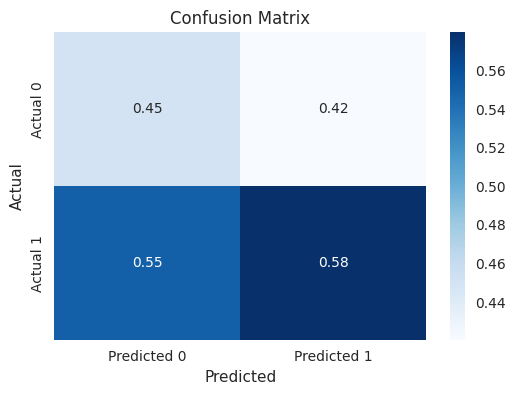

In [63]:
y_true = new_df[new_df.split=='test'][to_predict]
y_pred = new_df[new_df.split=='test'][pred3]

cm = confusion_matrix(y_true, y_pred, normalize='pred')

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', 
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [64]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.97      0.61     14100
           1       0.58      0.03      0.06     17308

    accuracy                           0.45     31408
   macro avg       0.51      0.50      0.34     31408
weighted avg       0.52      0.45      0.31     31408



**Answer**: The precision score for the best of the new predictions (pred3) is 0.580

### Question 3: Unique Correct Predictions from a 10-Level Decision Tree Classifier (`pred5_clf_10`)

**What is the total number of records in the TEST dataset where the new prediction `pred5_clf_10` is correct, while all 'hand' rule predictions (`pred0` to `pred4`) are incorrect?**


To ensure reproducibility, please include the following parameter in the Decision Tree Classifier:
```python
clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42) 
```


#### Step 1: Train the Decision Tree and Generate Predictions

- Initialize a Decision Tree Classifier with a maximum depth of 10 and set `random_state=42` for reproducibility.
- Fit the classifier on the combined TRAIN and VALIDATION datasets.
- Use the trained model to predict on the entire dataset (TRAIN + VALIDATION + TEST).
- Store these predictions in a new column named `pred5_clf_10` within your main dataframe.
- **Hint**: When predicting on the entire dataset, it's easy to join the predictions with the full DataFrame, since the number of records and their order remain the same. You will need to define X_all and y_all and apply the same cleaning steps used previously for X_train, y_train, X_test, and y_test. This makes it straightforward to define a new column, for example:  
  ```python
  df['pred5_clf_10'] = <predictions vector from clf10.predict(X_all)>

#### Step 2: Identify Unique Correct Predictions by `pred5_clf_10`

- Create a new boolean column, `only_pred5_is_correct`, that is `True` only when:
  - The prediction from `pred5_clf_10` is correct (i.e., matches the true label).
  - All other hand rule predictions (`pred0` through `pred4`) are incorrect.

#### Step 3: Count Unique Correct Predictions on the TEST Set

- Convert the `only_pred5_is_correct` column from boolean to integer.
- Filter the dataframe for records belonging to the TEST dataset.
- Count how many records in the TEST set have `only_pred5_is_correct` equal to 1.
- Report this count as your final answer.

### Advanced (Optional)

- To generalize this for many prediction columns (e.g., `pred0` to `pred99`), define a function that can be applied to an entire dataframe row.
- This function should identify whether a specific prediction (`predX`) is uniquely correct (correct while all others are incorrect).
- This approach avoids hardcoding conditions for each predictor and scales easily.
- For examples of how to apply functions to rows in pandas, see this helpful resource:  
  [Pandas apply function to every row](https://sparkbyexamples.com/pandas/pandas-apply-function-to-every-row/)

In [65]:
from sklearn.tree import DecisionTreeClassifier

In [66]:
clf = DecisionTreeClassifier(max_depth=10, random_state=42)

In [67]:
new_df.split.value_counts()

split
train         129730
test           31408
validation     30657
Name: count, dtype: int64

In [68]:
new_df.groupby('split')[to_predict].count()

split
test           31408
train         129730
validation     30657
Name: is_positive_growth_30d_future, dtype: int64

In [69]:
new_df.split.isin(['train', 'validation']).value_counts()

split
True     160387
False     31408
Name: count, dtype: int64

In [70]:
num_columns = new_df.select_dtypes(include=['number']).columns
len(new_df.columns), len(num_columns)

(264, 254)

In [71]:
print("Infinity check:")
print(new_df.replace([np.inf, -np.inf], np.nan).isnull().sum().sort_values()[::-1])

Infinity check:
growth_btc_usd_365d    112775
growth_btc_usd_90d     106720
growth_btc_usd_30d     105424
growth_btc_usd_7d      104902
growth_btc_usd_3d      104838
                        ...  
cdltasukigap                0
cdltakuru                   0
cdlsticksandwich            0
cdlstalledpattern           0
Open                        0
Length: 264, dtype: int64


In [72]:
pred_columns = new_df.columns[new_df.columns.str.contains('pred')].sort_values().tolist()
pred_columns

['pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds']

In [73]:
OHLCV = ['Open','High','Low','Close','Adj Close_x','Volume']
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']
TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Adj Close_y'] + CATEGORICAL + OHLCV + pred_columns
print(TO_DROP)

['Year', 'Date', 'index_x', 'index_y', 'index', 'Quarter', 'Adj Close_y', 'Month', 'Weekday', 'Ticker', 'ticker_type', 'Open', 'High', 'Low', 'Close', 'Adj Close_x', 'Volume', 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds']


In [74]:
TO_PREDICT = [g for g in new_df.columns if (g.find('future')>=0)]
TO_PREDICT

['growth_future_30d', 'is_positive_growth_30d_future']

In [75]:
X_train = new_df[new_df.split.isin(['train', 'validation'])][num_columns].drop(columns=TO_PREDICT+TO_DROP, errors='ignore')
y_train = new_df[new_df.split.isin(['train', 'validation'])][to_predict]

X_test = new_df[num_columns].drop(columns=TO_PREDICT+TO_DROP, errors='ignore')
y_test = new_df[to_predict]

X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((160387, 244), (160387,), (191795, 244), (191795,))

In [76]:
clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [77]:
y_pred = clf.predict(X_test)

new_df['pred5_clf_10'] = y_pred

In [78]:
precision_score(y_test, y_pred)

0.6976181296320096

In [79]:
pd.Series(clf.feature_importances_, index=clf.feature_names_in_).sort_values()[::-1][:20]

DGS10                    0.077948
DGS1                     0.058049
cpi_core_yoy             0.044870
growth_gold_365d         0.043089
ad                       0.033198
growth_snp500_90d        0.031808
obv                      0.029891
cpi_core_mom             0.029691
growth_wti_oil_365d      0.028697
growth_gold_30d          0.027340
growth_brent_oil_365d    0.027050
growth_365d              0.026273
growth_dax_90d           0.023995
DGS5                     0.022901
trix                     0.022335
growth_dax_30d           0.020849
FEDFUNDS                 0.019476
growth_90d               0.016852
growth_epi_30d           0.016683
growth_wti_oil_90d       0.016480
dtype: float64

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.46      0.55     78069
           1       0.70      0.86      0.77    113726

    accuracy                           0.70    191795
   macro avg       0.69      0.66      0.66    191795
weighted avg       0.69      0.70      0.68    191795



In [81]:
new_df['pred0_manual_cci'] = (new_df.cci>200).astype(int)
new_df['pred1_manual_prev_g1'] = (new_df.growth_30d>1).astype(int)
new_df['pred2_manual_prev_g1_and_snp'] = ((new_df['growth_30d'] > 1) & (new_df['growth_snp500_30d'] > 1)).astype(int)

In [82]:
pred_columns = new_df.columns[new_df.columns.str.contains('pred')].sort_values().to_list()
pred_columns

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds',
 'pred5_clf_10']

In [83]:
for col in pred_columns:
    prec = precision_score(
        y_true=new_df[to_predict],
        y_pred=new_df[col])
    print(f"{col:30} {round(prec, 3)}")

pred0_manual_cci               0.585
pred1_manual_prev_g1           0.583
pred2_manual_prev_g1_and_snp   0.581
pred3_manual_dgs10_5           0.677
pred4_manual_dgs10_fedfunds    0.539
pred5_clf_10                   0.698


In [84]:
#only_pred5_is_correct

new_df[pred_columns].astype(int).apply(lambda x: x.value_counts())

,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_dgs10_5,pred4_manual_dgs10_fedfunds,pred5_clf_10
0,186687,77711,104329,165557,155524,51737
1,5108,114084,87466,26238,36271,140058


In [85]:
new_df[pred_columns].astype(int).any(axis=1).value_counts()

True     177066
False     14729
Name: count, dtype: int64

In [86]:
new_df[pred_columns].astype(int).all(axis=1).value_counts()

False    191795
Name: count, dtype: int64

In [87]:
new_df[pred_columns+[to_predict]].astype(int).mean()

pred0_manual_cci                 0.026633
pred1_manual_prev_g1             0.594823
pred2_manual_prev_g1_and_snp     0.456039
pred3_manual_dgs10_5             0.136802
pred4_manual_dgs10_fedfunds      0.189113
pred5_clf_10                     0.730248
is_positive_growth_30d_future    0.592956
dtype: float64

In [88]:
comparison = new_df[pred_columns].astype(int).eq(new_df[to_predict], axis=0)

comparison.apply(lambda x: x.value_counts())

,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_dgs10_5,pred4_manual_dgs10_fedfunds,pred5_clf_10
False,112862,94834,99534,104442,110907,58370
True,78933,96961,92261,87353,80888,133425


In [89]:
comparison.mean()

pred0_manual_cci                0.411549
pred1_manual_prev_g1            0.505545
pred2_manual_prev_g1_and_snp    0.481040
pred3_manual_dgs10_5            0.455450
pred4_manual_dgs10_fedfunds     0.421742
pred5_clf_10                    0.695665
dtype: float64

In [90]:
(~comparison.drop(columns=['pred5_clf_10'])).all(axis=1).value_counts()

False    160158
True      31637
Name: count, dtype: int64

In [91]:
new_df['only_pred5_is_correct'] = ((~comparison.drop(columns=['pred5_clf_10'])).all(axis=1) & comparison['pred5_clf_10'])

In [92]:
new_df['only_pred5_is_correct'].value_counts()

only_pred5_is_correct
False    165228
True      26567
Name: count, dtype: int64

In [93]:
new_df[['only_pred5_is_correct','split']].groupby('split').agg(['count', 'sum', 'mean'])

only_pred5_is_correct                 
                           count    sum      mean
split                                            
test                       31408   3768  0.119969
train                     129730  19069  0.146990
validation                 30657   3730  0.121669

**Answer**: The total number of records in the TEST dataset where the new prediction pred5_clf_10 is correct, while all 'hand' rule predictions (pred0 to pred4) are incorrect is about 3770

### Question 4:  Hyperparameter tuning for a Decision Tree


**What is the optimal tree depth (from 1 to 20) for a DecisionTreeClassifier?**

**NOTE:** please include `random_state=42` to the Decision Tree Classifier initialization (e.g., `clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)`) to ensure consistency in results.

### Instructions:

- Iterate through `max_depth` values from 1 to 20.
- For each `max_depth`:
  - Train a Decision Tree Classifier with the current `max_depth` on the combined TRAIN+VALIDATION dataset.
- Optionally, visualize how the 'head' (top levels) of each fitted tree changes with increasing tree depth. You can use:
  - [`sklearn.tree.plot_tree()`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) for graphical visualization, or
  - The compact textual approach with `export_text()` function. For example:
    ```python
    from sklearn.tree import export_text
    tree_rules = export_text(model, feature_names=list(X_train), max_depth=3)
    print(tree_rules)
    ```
- Calculate the precision score on the TEST dataset for each fitted tree. You may also track precision on the VALIDATION dataset to observe signs of overfitting.
- Identify the optimal `max_depth` where the precision score on the TEST dataset is highest. This value is your **best_max_depth**.
- Using **best_max_depth**, retrain the Decision Tree Classifier on the combined TRAIN+VALIDATION set.
- Predict on the entire dataset (TRAIN + VALIDATION + TEST) and add the predictions as a new column `pred6_clf_best` in your dataframe `new_df`.
- Compare the precision score of the tuned tree with previous predictions (`pred0` to `pred5`). You should observe an improvement, ideally achieving precision > 0.58, indicating the tuned tree outperforms earlier models.

### Advanced (Optional)

- Plot the precision (or accuracy) scores against the `max_depth` values to detect saturation or overfitting trends.
- Observe the trade-off between model complexity (deeper trees) and generalization capability.
- For more information, consult the [scikit-learn Decision Trees documentation](https://scikit-learn.org/stable/modules/tree.html).

In [94]:
X_train = new_df[new_df.split.isin(['train', 'validation'])][num_columns].drop(columns=TO_PREDICT+TO_DROP, errors='ignore')
y_train = new_df[new_df.split.isin(['train', 'validation'])][to_predict]

X_test = new_df[new_df.split.isin(['test'])][num_columns].drop(columns=TO_PREDICT+TO_DROP, errors='ignore')
y_test = new_df[new_df.split.isin(['test'])][to_predict]

X_val = new_df[new_df.split.isin(['validation'])][num_columns].drop(columns=TO_PREDICT+TO_DROP, errors='ignore')
y_val = new_df[new_df.split.isin(['validation'])][to_predict]

X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
X_val = X_val.replace([np.inf, -np.inf], np.nan).fillna(0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((160387, 244), (160387,), (31408, 244), (31408,))

In [95]:
import tqdm

In [96]:
trained_clf = dict()

for i in tqdm.tqdm(range(1,20+1)):
    clf = DecisionTreeClassifier(max_depth=i, random_state=42)
    clf.fit(X_train, y_train)
    trained_clf[i] = clf

100%|██████████| 20/20 [07:30<00:00, 22.53s/it]


In [97]:
from sklearn.tree import export_text, plot_tree
tree_rules = export_text(trained_clf[5], feature_names=list(X_train), max_depth=3)
print(tree_rules)

|--- DGS10 <= 4.83
|   |--- DGS5 <= 0.75
|   |   |--- growth_dax_90d <= 1.13
|   |   |   |--- growth_365d <= 1.48
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- growth_365d >  1.48
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- growth_dax_90d >  1.13
|   |   |   |--- obv <= 663286816.00
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- obv >  663286816.00
|   |   |   |   |--- truncated branch of depth 2
|   |--- DGS5 >  0.75
|   |   |--- DGS1 <= 4.06
|   |   |   |--- growth_gold_365d <= 1.27
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- growth_gold_365d >  1.27
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- DGS1 >  4.06
|   |   |   |--- growth_dax_90d <= 1.11
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- growth_dax_90d >  1.11
|   |   |   |   |--- truncated branch of depth 2
|--- DGS10 >  4.83
|   |--- FEDFUNDS <= 4.80
|   |   |--- growth_wti_oil_90d <= 0.91
|   |   |   |--- growth_

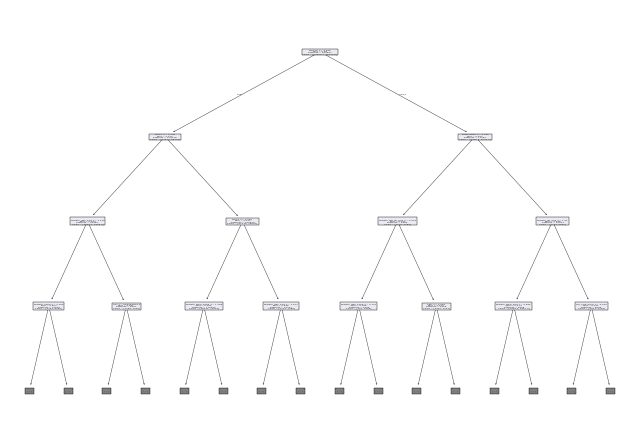

In [98]:
plot_tree(trained_clf[5], feature_names=list(X_train), max_depth=3);

In [99]:
pd.Series(trained_clf[5].feature_importances_, index=trained_clf[5].feature_names_in_).sort_values()[::-1].head(10)

DGS1                     0.175577
DGS10                    0.149962
growth_gold_365d         0.082250
growth_dax_90d           0.078977
DGS5                     0.074241
growth_brent_oil_365d    0.064719
growth_wti_oil_90d       0.057802
FEDFUNDS                 0.056204
growth_dji_90d           0.035338
growth_gold_90d          0.026421
dtype: float64

In [100]:
feat_importances = dict()

for i in tqdm.tqdm(range(1,20+1)):
    feat_importances[i] = pd.Series(trained_clf[i].feature_importances_, index=trained_clf[i].feature_names_in_)

100%|██████████| 20/20 [00:00<00:00, 2316.21it/s]


In [101]:
feat_importances_df = pd.concat(feat_importances, axis=1).sort_values(20)[::-1]
feat_importances_df.head(10)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
ad,0.0,0.0000,0.000000,0.000000,0.014187,0.024048,0.027782,0.029165,0.032016,0.033198,0.033219,0.035411,0.035751,0.035079,0.037191,0.038182,0.040084,0.039654,0.042693,0.041050
obv,0.0,0.0000,0.000000,0.012687,0.008577,0.014229,0.018494,0.016482,0.022389,0.029891,0.027946,0.032203,0.032436,0.034870,0.037375,0.039852,0.040461,0.038654,0.038287,0.039129
growth_365d,0.0,0.0000,0.000000,0.019295,0.013044,0.013374,0.014627,0.018447,0.026400,0.026273,0.027611,0.028012,0.033213,0.031895,0.034134,0.035571,0.036245,0.037570,0.038092,0.038973
trix,0.0,0.0000,0.000000,0.000000,0.007888,0.014965,0.013907,0.016119,0.020451,0.022335,0.027251,0.026816,0.028040,0.027036,0.028573,0.027479,0.032125,0.030949,0.030373,0.030196
DGS10,1.0,0.5348,0.317944,0.221828,0.149962,0.107200,0.083829,0.103329,0.092032,0.077948,0.067222,0.056400,0.049600,0.044271,0.042711,0.036686,0.033571,0.031784,0.029039,0.029190
adxr,0.0,0.0000,0.000000,0.000000,0.011722,0.011468,0.008968,0.007858,0.012283,0.015047,0.018765,0.018639,0.019824,0.022340,0.021907,0.022817,0.025125,0.024920,0.024605,0.025946
DGS1,0.0,0.0000,0.139258,0.097160,0.175577,0.125511,0.098148,0.075554,0.066189,0.058049,0.049634,0.043144,0.038985,0.034626,0.031837,0.029491,0.026819,0.025674,0.024579,0.022940
volatility,0.0,0.0000,0.000000,0.000000,0.021085,0.015072,0.014080,0.014195,0.017418,0.016358,0.019052,0.019963,0.020693,0.022098,0.023682,0.022232,0.023788,0.022647,0.022554,0.022399
cpi_core_yoy,0.0,0.0000,0.000000,0.000000,0.000000,0.007717,0.053905,0.042999,0.045376,0.044870,0.043454,0.040873,0.034761,0.033485,0.028971,0.027544,0.025579,0.023474,0.023248,0.021768
growth_90d,0.0,0.0000,0.000000,0.000000,0.000000,0.007588,0.007549,0.005811,0.014462,0.016852,0.016209,0.014782,0.015399,0.017003,0.016983,0.018700,0.019632,0.021149,0.020494,0.020633


Text(0.5, 1.0, 'Feature importances')

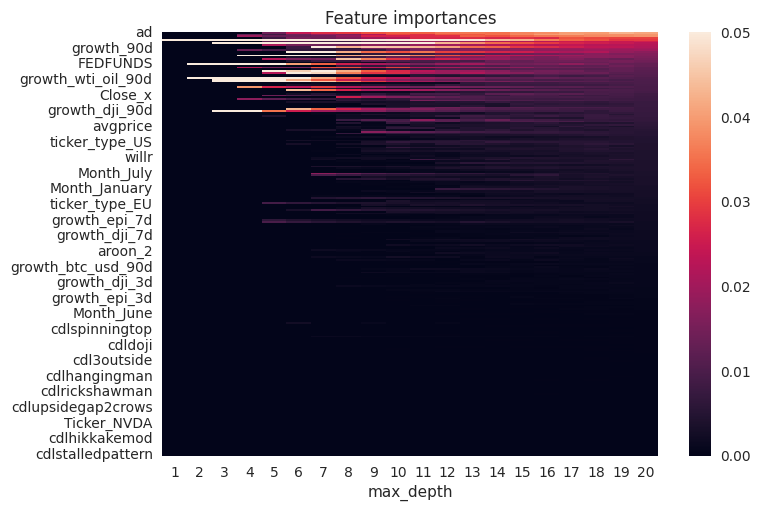

In [102]:
sns.heatmap(feat_importances_df, vmax=0.05, vmin=0)
plt.xlabel('max_depth')
plt.title('Feature importances')

In [103]:
precision_clf = dict()

for i in tqdm.tqdm(range(1,20+1)):
    y_pred = trained_clf[i].predict(X_test)
    y_pred2 = trained_clf[i].predict(X_val)
    precision_clf[i] = precision_score(y_test, y_pred) , precision_score(y_val, y_pred2)

100%|██████████| 20/20 [00:01<00:00, 17.87it/s]


Text(0, 0.5, 'precision_score')

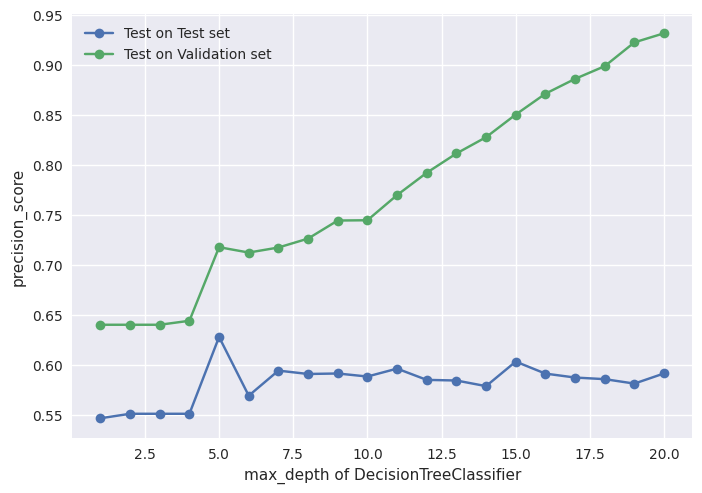

In [104]:
pd.DataFrame(precision_clf, index=['Test on Test set','Test on Validation set']).T.plot(style='o-')
plt.xlabel('max_depth of DecisionTreeClassifier')
plt.ylabel('precision_score')

The DecisionTreeClassifier was trained on a combination of Train and Validation sets.

It is clear that when tested on the Validation set for greater max_depths it turns out to be overfitted.

In [106]:
t_ = pd.DataFrame(precision_clf, index=['Test on Test set','Test on Validation set']).T#.head()
t_.style.background_gradient(subset=pd.IndexSlice[:, t_.columns[0]])

,Test on Test set,Test on Validation set
1,0.546582,0.640050
2,0.551070,0.640050
3,0.551070,0.640050
4,0.551070,0.644022
5,0.627845,0.717586
6,0.569142,0.712213
7,0.594213,0.717254
8,0.590848,0.726161
9,0.591334,0.744231
10,0.588304,0.744499


In [107]:
best_max_depth = pd.DataFrame(precision_clf).T[0].idxmax()
best_max_depth 

np.int64(5)

In [108]:
X_test = new_df[num_columns].drop(columns=TO_PREDICT+TO_DROP, errors='ignore')
y_test = new_df[to_predict]

X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
X_val = X_val.replace([np.inf, -np.inf], np.nan).fillna(0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((160387, 244), (160387,), (191795, 244), (191795,))

In [109]:
y_pred = trained_clf[best_max_depth].predict(X_test)

new_df['pred6_clf_best'] = y_pred

In [110]:
pred_columns = new_df.columns[new_df.columns.str.startswith('pred')].sort_values().to_list()
pred_columns

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds',
 'pred5_clf_10',
 'pred6_clf_best']

In [111]:
for col in pred_columns:
    prec = precision_score(
        y_true=new_df[to_predict],
        y_pred=new_df[col])
    print(f"{col:30} {round(prec, 3)}")

pred0_manual_cci               0.585
pred1_manual_prev_g1           0.583
pred2_manual_prev_g1_and_snp   0.581
pred3_manual_dgs10_5           0.677
pred4_manual_dgs10_fedfunds    0.539
pred5_clf_10                   0.698
pred6_clf_best                 0.65


**Answer**: The optimal tree depth for a DecisionTreeClassifier for our case is 5.

### [EXPLORATORY] Question 5: What data is missing? 

Now that you have gained insights from the correlation analysis and Decision Tree results regarding the most influential variables, suggest new indicators you would like to include in the dataset and explain your reasoning.

Alternatively, you may propose a completely different approach based on your intuition, provided it remains relevant to the shared dataset of the largest stocks from India, the EU, and the US. If you choose this route, please also specify the data source.

**Answer**

To enhance the dataset's predictive capabilities, I recommend integrating region-specific macro data, behavioral indicators, and structural market signals that capture dynamics not currently represented.

🔍 Key Missing Data
1. Regional Macro Conditions

- Policy divergence: Track central bank balance sheets (ECB, RBI) to capture monetary stance beyond rates

- Labor market health: Include unemployment rates and wage growth for each region

- Credit conditions: Loan growth and non-performing loan ratios (NPLs) as proxies for credit cycle phases

2. Market Dynamics & Structure

- Liquidity risk: Bid-ask spreads or turnover ratios for major indices

- Inter-market signals: Commodities (gold, copper) and real estate indices to reflect inflation and growth expectations

- Market breadth: Advance-decline ratios in US, EU, and Indian markets

3. Investor Behavior & Sentiment

- Retail investor trends: Trading volume shifts in retail-heavy stocks or platforms (e.g., Zerodha in India)

- News-based sentiment: NLP scores from regional financial news headlines

- Options market positioning: Put-call ratios and open interest changes

🌐 Proposed Data Sources
- BIS & IMF – for cross-border credit, policy tools

- Trading Economics & Investing.com – for labor and housing data

- OpenFIGI / Quandl – for cross-asset financial data

- Sentifi / RavenPack (if accessible) – for sentiment analytics

🎯 Why These Additions?
The current model emphasizes long-term price dynamics and rate sensitivity. However, adding these variables can:

- Capture economic inflection points (via credit, employment, and liquidity data)

- Reflect investor positioning and risk perception across regions

- Identify regime shifts early through market breadth and sentiment shifts

These layers offer a more nuanced view of how global investors react to region-specific signals, supporting a more adaptive and forward-looking model.